# Dependencies and Modules

To handle our data, we'll be using pandas, numpy, regex, datetime, and dateutil.

We'll use matlpotlib for our visualizations.

We also are using a unique file type feather so that our data can be compressed down smaller than a csv.

For our model fitting, we'll be using sklearn, xgboost, and lightgbm.

In [62]:
import pandas as pd
from matplotlib import pyplot as plt
import math
import re
import numpy as np
import feather
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from datetime import date
from dateutil.parser import isoparse
from pandas.plotting import table

### Data Import

In [4]:
raw_df = pd.read_csv('data/initial_data.csv')
raw_df.head()

FileNotFoundError: File b'data/initial_data.csv' does not exist

In [2]:
fixed_df = pd.read_csv('data/fixed_data_v1.csv')

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (54,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
feather.write_dataframe(fixed_df, 'data/fixed_data_v1.feather')

## Data Preprocessing

### Note: This does not need to be done after the file is saved again

In [2]:
fixed_df = feather.read_dataframe('data/fixed_data_v1.feather')
fixed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,season_type
0,59,2009080950,TEN,BUF,TEN,home,BUF,TEN,74.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
1,83,2009080950,TEN,BUF,TEN,home,BUF,TEN,64.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
2,104,2009080950,TEN,BUF,TEN,home,BUF,TEN,67.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
3,128,2009080950,TEN,BUF,TEN,home,BUF,TEN,55.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
4,152,2009080950,TEN,BUF,TEN,home,BUF,BUF,40.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre


In [16]:
fixed_df.columns

Index(['Unnamed: 0', 'level_0', 'index', 'play_id', 'game_id', 'home_team',
       'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field',
       'yardline_100', 'game_date', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'game_half',
       'drive', 'qtr', 'down', 'goal_to_go', 'time', 'ydstogo', 'ydsnet',
       'play_type', 'yards_gained', 'home_timeouts_remaining',
       'away_timeouts_remaining', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'total_home_score', 'total_away_score',
       'posteam_score', 'defteam_score', 'score_differential',
       'posteam_score_post', 'defteam_score_post', 'score_differential_post',
       'passer_player_name', 'rusher_player_name', 'passer_player_id',
       'rusher_player_id', 'season_type', 'desc', 'timeout', 'timeout_team',
       'td_team', 'interception', 'penalty', 'fumble_lost', 'sack',
       'touchdown', 'fumble', 'fumbled_1_team', 'fumbled_2_team',
       'fum

### Remove non-plays

Remove all rows of data that are not actually plays

In [85]:
fixed_df = raw_df.copy()
fixed_df = fixed_df[~fixed_df['desc'].str.contains("END QUARTER", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("END GAME", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("Two-Minute Warning", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of game", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of quarter", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of half", na=False)]
fixed_df.reset_index(inplace=True)

### Fill Possession Team  Missing Values

In [86]:
def fill_posteam(row):
    if not isinstance(row['posteam'], str) and math.isnan(row['posteam']):
        prev_idx = row.name - 1
        if row['drive'] == fixed_df['drive'][prev_idx]:
            while not isinstance(fixed_df['posteam'][prev_idx], str):
                prev_idx -= 1
            return fixed_df['posteam'][prev_idx]
        else:
            next_idx = row.name + 1
            while not isinstance(fixed_df['posteam'][next_idx], str):
                next_idx += 1
            return fixed_df['posteam'][next_idx]
    else:
        return row['posteam']

fixed_df['posteam'] = fixed_df.apply(lambda x: fill_posteam(x), axis=1)

### Fill Possession Team Type Missing Values

In [87]:
def fill_posteam_type(row):
    if not isinstance(row['posteam_type'], str) and math.isnan(row['posteam_type']):
        if row['posteam'] is row['home_team']:
            return 'home'
        else:
            return 'away'
    else:
        return row['posteam_type']

fixed_df['posteam_type'] = fixed_df.apply(lambda x: fill_posteam_type(x), axis=1)

### Fill Defense Team Missing Values

In [88]:
def fill_defteam(row):
    if not isinstance(row['defteam'], str) and math.isnan(row['defteam']):
        if row['posteam'] is row['home_team']:
            return row['away_team']
        else:
            return row['home_team']
    else:
        return row['defteam']

fixed_df['defteam'] = fixed_df.apply(lambda x: fill_defteam(x), axis=1)

### Fill Posteam Timeouts Remaining

In [89]:
def fill_posteam_timeouts_remaining(row):
    if math.isnan(row['posteam_timeouts_remaining']):
        if row['posteam'] is row['home_team']:
            return row['home_timeouts_remaining']
        else:
            return row['away_timeouts_remaining']
    else:
        return row['posteam_timeouts_remaining']

fixed_df['posteam_timeouts_remaining'] = fixed_df.apply(lambda x: fill_posteam_timeouts_remaining(x), axis=1)

### Fill Defteam Timeouts Remaining

In [90]:
def fill_defteam_timeouts_remaining(row):
    if math.isnan(row['defteam_timeouts_remaining']):
        if row['defteam'] is row['home_team']:
            return row['home_timeouts_remaining']
        else:
            return row['away_timeouts_remaining']
    else:
        return row['defteam_timeouts_remaining']

fixed_df['defteam_timeouts_remaining'] = fixed_df.apply(lambda x: fill_defteam_timeouts_remaining(x), axis=1)

### Fill Posteam Score

In [91]:
def fill_posteam_score(row):
    if math.isnan(row['posteam_score']):
        if row['posteam'] is row['home_team']:
            return row['total_home_score']
        else:
            return row['total_away_score']
    else:
        return row['posteam_score']

fixed_df['posteam_score'] = fixed_df.apply(lambda x: fill_posteam_score(x), axis=1)

### Fill Defteam Score

In [92]:
def fill_defteam_score(row):
    if math.isnan(row['defteam_score']):
        if row['defteam'] is row['home_team']:
            return row['total_home_score']
        else:
            return row['total_away_score']
    else:
        return row['defteam_score']
    
fixed_df['defteam_score'] = fixed_df.apply(lambda x: fill_defteam_score(x), axis=1)

### Fill Score Differential

In [93]:
def fill_score_differential(row):
    return row['posteam_score'] - row['defteam_score']

fixed_df['score_differential'] = fixed_df.apply(lambda x: fill_score_differential(x), axis=1)

### Fill Down

In [106]:
def fill_down(row):
    if math.isnan(row['down']):
        if row['timeout'] == 1:
            prev_idx = row.name - 1
            while math.isnan(fixed_df['down'][prev_idx]):
                prev_idx -= 1
            return fixed_df['down'][prev_idx]
        else:
            return 'N/A'
    else:
        return row['down']

fixed_df['down'] = fixed_df.apply(lambda x: fill_down(x), axis=1)

### Fill Side of Field Missing Values

In [94]:
def fill_side_of_field(row):
    if not isinstance(row['side_of_field'], str) and math.isnan(row['side_of_field']):
        prev_idx = row.name - 1
        while not isinstance(fixed_df['side_of_field'][prev_idx], str):
            prev_idx -=1
        return fixed_df['side_of_field'][prev_idx]
    else:
        return row['side_of_field']

fixed_df['side_of_field'] = fixed_df.apply(lambda x: fill_side_of_field(x), axis=1)

### Fill Yardline 100 Missing Values

In [95]:
def fill_yardline_100(row):
    if math.isnan(row['yardline_100']):
        prev_idx = row.name - 1
        while math.isnan(fixed_df['yardline_100'][prev_idx]):
            prev_idx -= 1
        return fixed_df['yardline_100'][prev_idx] - fixed_df['yards_gained'][prev_idx]
    else:
        return row['yardline_100']

fixed_df['yardline_100'] = fixed_df.apply(lambda x: fill_yardline_100(x), axis=1)

### Fix Incorrect Plays

In [20]:
def fix_incorrect_plays(row):
    if isinstance(row['desc'], str) and row['desc'].lower().find("scramble") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("pass") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("punt") != -1:
        return 'punt'
    elif isinstance(row['desc'], str) and row['timeout'] == 1 and row['timeout_team'] is row['posteam']:
        return 'timeout'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("kicks") != -1 and row['play_type'] != 'extra_point' and row['play_type'] != "field_goal":
        return 'kickoff'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("sack") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("spike") != -1:
        return 'qb_spike'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("field goal") != -1:
        return 'field_goal'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and re.findall("for -*\d+ yard", row['desc']):
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and re.findall("for -*\d+ yard", row['desc']):
        return 'run'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and row['desc'].lower().find("no gain") != -1:
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and row['desc'].lower().find("no gain") != -1:
        return 'run'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and row['desc'].lower().find('run')!= -1:
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and row['desc'].lower().find('run') != -1:
        return 'run'
    else:
        return row['play_type']

fixed_df['play_type'] = fixed_df.apply(lambda x: fix_incorrect_plays(x), axis=1)
fixed_df.dropna(subset=['play_type'],inplace=True)

### Fill Yards Gained

In [158]:
def fill_yards_gained(row):
    if math.isnan(row['yards_gained']):
        if row['play_type'] == 'pass' or row['play_type'] == 'run' or row['play_type'] == 'qb_kneel':
            prev_idx = row.name - 1
            return row['yardline_100'] - fixed_df['yardline_100'][prev_idx]
    else:
        return row['yards_gained']
    
fixed_df['yards_gained'] = fixed_df.apply(lambda x: fill_yards_gained(x), axis=1)

### Fill Other NaNs

In [145]:
fixed_df.dropna(subset=['time'], inplace=True)
fixed_df['passer_player_name'].fillna('N/A', inplace=True)
fixed_df['passer_player_id'].fillna('N/A', inplace=True)
fixed_df['rusher_player_name'].fillna('N/A', inplace=True)
fixed_df['rusher_player_id'].fillna('N/A', inplace=True)
fixed_df['timeout'].fillna(np.float64(0), inplace=True)
fixed_df['timeout_team'].fillna('N/A', inplace=True)
fixed_df['td_team'].fillna('N/A', inplace=True)
fixed_df['interception'].fillna(np.float64(0), inplace=True)
fixed_df['penalty'].fillna(np.float64(0), inplace=True)
fixed_df['fumble_lost'].fillna(np.float64(0), inplace=True)
fixed_df['sack'].fillna(np.float64(0), inplace=True)
fixed_df['touchdown'].fillna(np.float64(0), inplace=True)
fixed_df['fumble'].fillna(np.float64(0), inplace=True)
fixed_df['fumbled_1_team'].fillna('N/A', inplace=True)
fixed_df['fumbled_2_team'].fillna('N/A', inplace=True)
fixed_df['fumble_recovery_1_team'].fillna('N/A', inplace=True)
fixed_df['fumble_recovery_2_team'].fillna('N/A', inplace=True)
fixed_df['goal_to_go'].fillna(np.float64(0), inplace=True)

### Fill Posession Team Score Post

In [147]:
def fill_posteam_score_post(row):
    if math.isnan(row['posteam_score_post']):
        if row['touchdown'] == 1 and row['interception'] == 0 and row['fumble_lost'] == 0:
            return row['posteam_score'] + 6
        else:
            return row['posteam_score']
    else:
        return row['posteam_score_post']
    
fixed_df['posteam_score_post'] = fixed_df.apply(lambda x: fill_posteam_score_post(x), axis=1)

### Fill Defensive Team Score Post

In [150]:
def fill_defteam_score_post(row):
    if math.isnan(row['defteam_score_post']):
        if row['touchdown'] == 1 and row['interception'] == 1:
            return row['defteam_score'] + 6
        elif row['touchdown'] == 1 and row['fumble_recovery'] == 1:
            return row['defteam_score'] + 6
        else:
            return row['defteam_score']
    else:
        return row['defteam_score_post']
    
fixed_df['defteam_score_post'] = fixed_df.apply(lambda x: fill_defteam_score_post(x), axis=1)

### Fill Score Differential Post

In [152]:
def fill_score_differential_post(row):
    if math.isnan(row['score_differential_post']):
        return row['posteam_score_post'] - row['defteam_score_post']
    else:
        return row['score_differential_post']

fixed_df['score_differential_post'] = fixed_df.apply(lambda x: fill_score_differential_post(x), axis=1)

### Drop Yardline Column and Reset Index

In [160]:
fixed_df.drop(['yrdln'], axis=1, inplace=True)
fixed_df.reset_index(inplace=True)

### Drop Values Not Worth Predicting

In [25]:
value_list = ['qb_kneel', 'extra_point', 'kickoff', 'no_play', 'extra_point', 'qb_spike']
index_list = []
for value in value_list:
    index_list += list(fixed_df[fixed_df['play_type'] == value].index)
fixed_df.drop(index_list, inplace=True)
fixed_df.reset_index(inplace=True)

ValueError: cannot insert level_0, already exists

### Fix Moved Team Names

In [48]:
def fix_team_names(team):
    if team == 'JAC':
        return 'JAX'
    elif team == 'STL':
        return 'LA'
    elif team == 'SD':
        return 'LAC'
    else:
        return team
fixed_df['home_team'] = fixed_df['home_team'].apply(lambda x: fix_team_names(x))
fixed_df['away_team'] = fixed_df['away_team'].apply(lambda x: fix_team_names(x))
fixed_df['posteam'] = fixed_df['posteam'].apply(lambda x: fix_team_names(x))
fixed_df['defteam'] = fixed_df['defteam'].apply(lambda x: fix_team_names(x))

### Save Cleaned Data

In [37]:
file = open('data/fixed_data_v1.csv', 'w')
fixed_df.to_csv(file)

# Data Visualization

Next we're going to take a look at the data visualizations for our data.

### Play Types

As you can see from the chart below, the two largest categories are pass plays and run plays. However, there is still a significant number of punts and field goals.

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

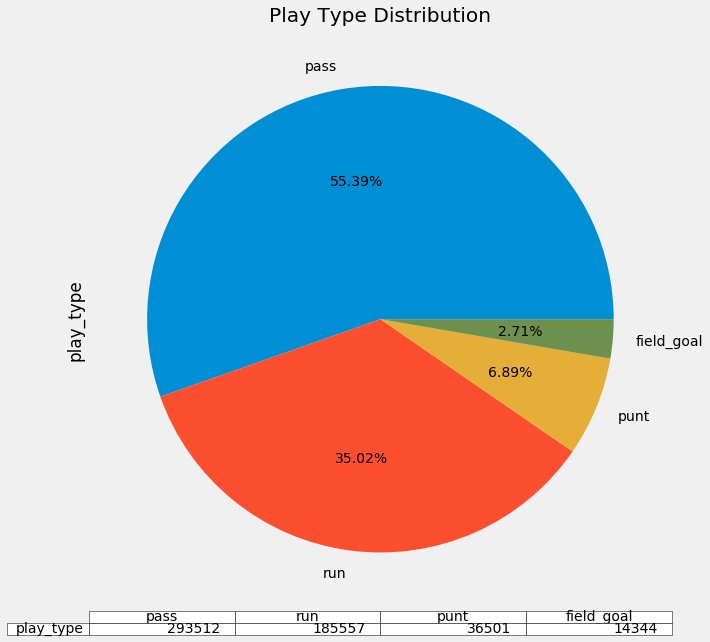

In [68]:
plt.style.use("fivethirtyeight")
fixed_df['play_type'].value_counts().plot.pie(figsize=(16, 10), title="Play Type Distribution", 
                                              table=True, autopct="%.2f%%")

### Pass Plays Based On Score Differential

The general consensus is that if you are losing in a football game, you have to call more pass plays as they take up less clock and typically can be for more yards gained. We're going to explore that by looking at a score differential by pass play scatter plot.

In [16]:
def sum_up_plays(game_id):
    sub_df = fixed_df[fixed_df['game_id'] == game_id]
    for drive in sub_df['drive'].unique():
        if math.isnan(sub_df[sub_df['drive'] == drive]['score_differential'].values[0]):
            if len(sub_df[sub_df['drive'] == drive]['score_differential'].values) == 1:
                continue
            else:
                score = sub_df[sub_df['drive'] == drive]['score_differential'].values[1]
        else:
            score = sub_df[sub_df['drive'] == drive]['score_differential'].values[0]
        pass_plays = 0
        for play in sub_df[sub_df['drive'] == drive]['play_type'].values:
            if play == 'pass':
                pass_plays += 1
        if score in scores_and_plays.keys():
            scores_and_plays[score].append(pass_plays)
        else:
            scores_and_plays[score] = [pass_plays]

In [17]:
scores_and_plays = {}
for game in fixed_df['game_id'].unique():
    sum_up_plays(game)

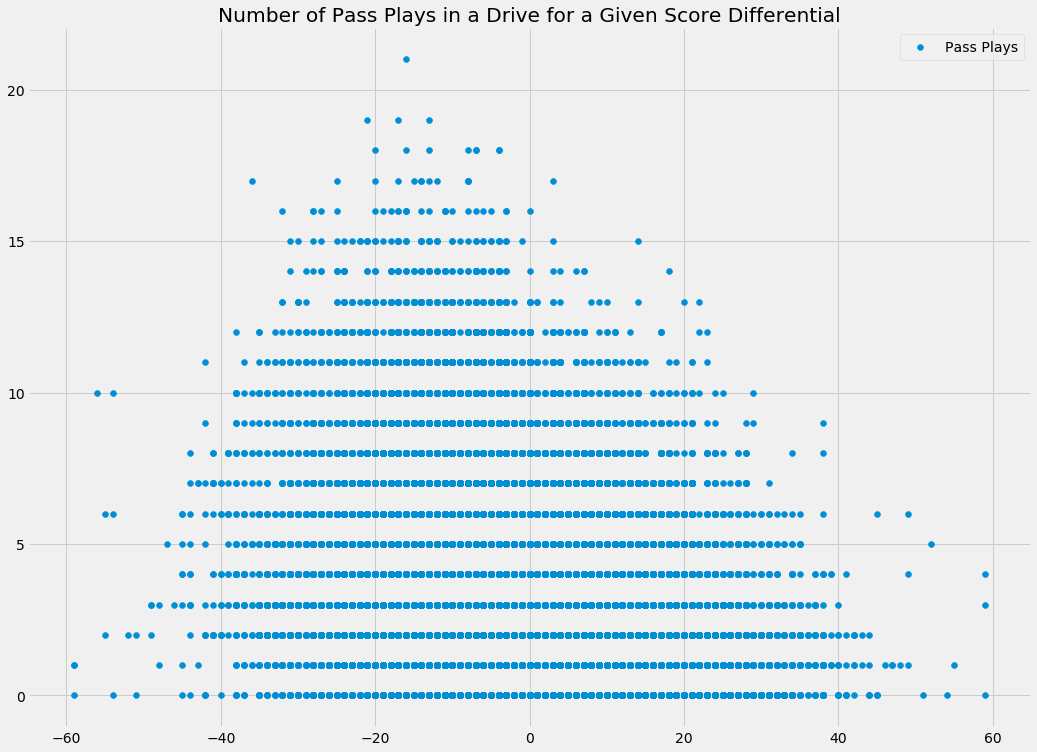

In [69]:
x = []
y = []
for pair in scores_and_plays.items():
    for plays in pair[1]:
        y.append(plays)
        x.append(pair[0])
plt.figure(figsize=(16, 12))
plt.scatter(x, y)
plt.title("Number of Pass Plays in a Drive for a Given Score Differential")
plt.legend(['Pass Plays'])
plt.show()

While there is some peaking at what I would consider a comebackable score (less that three score deficit), it is definitely more evenely distributed that I thought it would be.

### Play Types per Down

Next, we're going to look at how the play down impacts the play types.

#### Play Types per First Down

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30cb7278>,
      dtype=object)

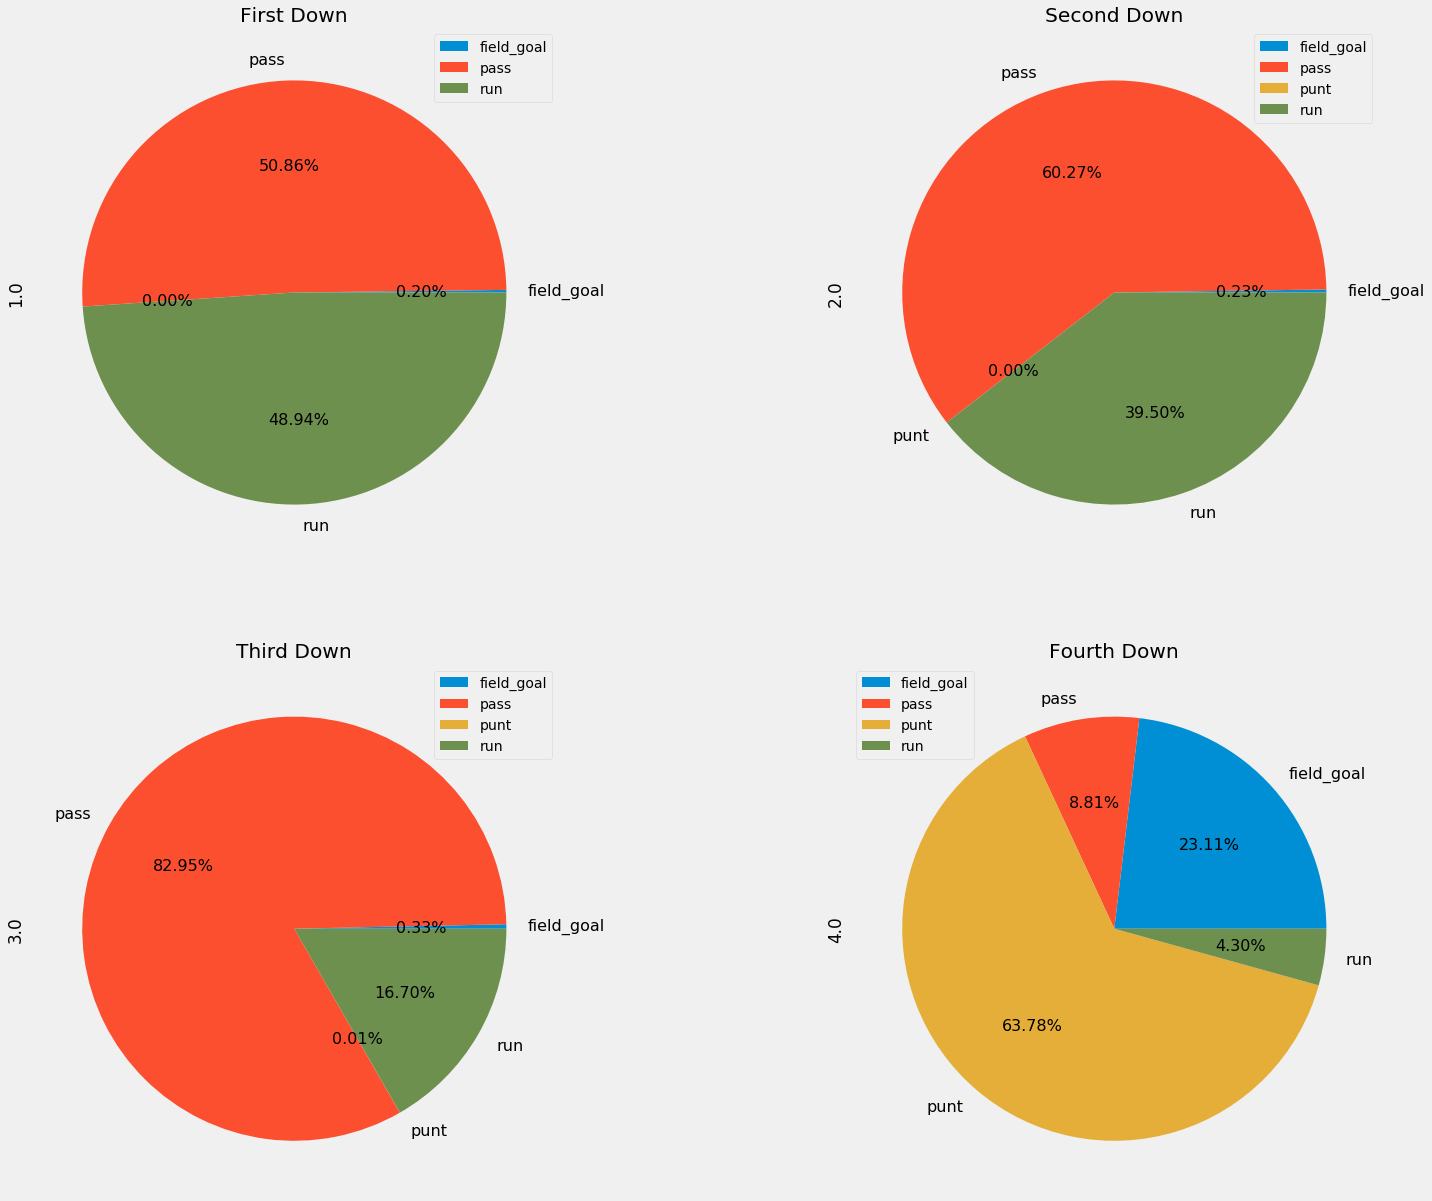

In [70]:
copy_df = fixed_df.copy()
copy_df['index'] = copy_df.index
copy_df.pivot_table(index="play_type",columns='down', values='index', aggfunc='count', fill_value=0).plot.pie(subplots=True, figsize=(24, 20),
                                                                                                              title=['First Down', 'Second Down',
                                                                                                                    'Third Down', 'Fourth Down'],
                                                                                                             layout=(2,2), autopct="%.2f%%",
                                                                                                             fontsize=16)

The most variability was shockingly 4th down, but third down as well become very dominantly pass plays over run plays.

### Cast Variables as Categorical

In [14]:
fixed_df['home_team'] = fixed_df['home_team'].astype('category')
fixed_df['away_team'] = fixed_df['away_team'].astype('category')
fixed_df['posteam'] = fixed_df['posteam'].astype('category')
fixed_df['defteam'] = fixed_df['defteam'].astype('category')
fixed_df['posteam_type'] = fixed_df['posteam_type'].astype('category')
fixed_df['side_of_field'] = fixed_df['side_of_field'].astype('category')
fixed_df['game_half'] = fixed_df['game_half'].astype('category')
fixed_df['qtr'] = fixed_df['qtr'].astype('category')
fixed_df['down'] = fixed_df['down'].astype('category')
fixed_df['home_timeouts_remaining'] = fixed_df['home_timeouts_remaining'].astype('category')
fixed_df['away_timeouts_remaining'] = fixed_df['away_timeouts_remaining'].astype('category')
fixed_df['posteam_timeouts_remaining'] = fixed_df['posteam_timeouts_remaining'].astype('category')
fixed_df['defteam_timeouts_remaining'] = fixed_df['defteam_timeouts_remaining'].astype('category')
fixed_df['season_type'] = fixed_df['season_type'].astype('category')

### Create Dummy Variables, Append to DataFrame, and Drop Original Column

In [4]:
def add_dummies_to_main_df(column, df):
    dummy_df = pd.get_dummies(fixed_df[column], prefix=column, drop_first=True)
    new_df = pd.concat([df, dummy_df], axis=1)
    new_df.drop(column, axis=1, inplace=True)
    return new_df

cat_columns = ['home_team', 'away_team', 'posteam', 'defteam', 'posteam_type', 'side_of_field', 'game_half', 'qtr',
              'down', 'home_timeouts_remaining', 'away_timeouts_remaining', 'posteam_timeouts_remaining',
              'defteam_timeouts_remaining', 'season_type']

for column in cat_columns:
    fixed_df = add_dummies_to_main_df(column, fixed_df)

# Test Machine Learning Models

### Set up Test Data

In [15]:
X = fixed_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = fixed_df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_sub = X.values[0:50000, :]
y_sub = y.values[0:50000]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

### Random Forest

In [20]:
rf_params = {'clf__criterion':['gini','entropy'],
             'clf__max_features': ['auto', 'sqrt', 'log2'],
             'clf__class_weight': ['balanced', 'balanced_subsample', None],
             'clf__max_depth': [15]}
rf = RandomForestClassifier()

In [21]:
pipe = Pipeline([('clf', rf)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=rf_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_rf = (gs.best_estimator_) 
print('Random Forest:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

Random Forest:
Best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__max_features': 'sqrt'}
Train Accuracy: 0.8666
Test Accuracy: 0.7963


### SGD Classifier

In [9]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}
sgd = SGDClassifier()

In [10]:
pipe = Pipeline([('clf', sgd)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=sgd_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_svm = (gs.best_estimator_) 
print('Schochastic Gradient Descent:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

Schochastic Gradient Descent:
Best params: {'clf__loss': 'hinge', 'clf__penalty': 'l1'}
Train Accuracy: 0.62455
Test Accuracy: 0.6315


### XGBoost

In [14]:
xg_params = {
    'clf__learning_rate': [0.1, 0.2],
    'clf__max_depth': [6],
    'clf__min_child_weight': [1, 2],
    'clf__subsample': [0.5, 0.7],
    'clf__n_estimators': [100],
}
xg = XGBClassifier()

In [15]:
pipe = Pipeline([('clf', xg)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=xg_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_svm = (gs.best_estimator_) 
print('XGBoost:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

XGBoost:
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__min_child_weight': 2, 'clf__n_estimators': 100, 'clf__subsample': 0.5}
Train Accuracy: 0.834875
Test Accuracy: 0.8195


### LightGBM

In [11]:
lgbm_params = {
    'clf__learning_rate': [0.1, 0.01, 0.03, 0.001],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [10, 50, 100, 500],
    'clf__max_depth': [10, 15, 20],
    'clf__num_leaves': [20, 31, 50, 100],
    'clf__boosting_type': ['gbdt', 'dart']
}
lgbm = LGBMClassifier()

In [12]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

LightGBM:
Best params: {'clf__boosting_type': 'gbdt', 'clf__class_weight': 'balanced', 'clf__learning_rate': 0.1, 'clf__max_bins': 10, 'clf__max_depth': 20, 'clf__metric': 'multi_logloss', 'clf__num_leaves': 50}
Train Accuracy: 0.8369
Test Accuracy: 0.8155


Based on the results, I'm going with the LightGBM model because it has roughly the same accuracy as the XGBoost but trains much faster.

# Refining LightGBM

### Using Categorical Variables Directly

In [2]:
dictionary_key = {
    'Teams': {
        'TEN': 1,
        'PHI': 2,
        'BAL': 3,
        'PIT': 4,
        'OAK': 5,
        'NYJ': 6,
        'IND': 7,
        'NO': 8,
        'SF': 9,
        'DET': 10,
        'BUF': 11,
        'GB': 12,
        'KC': 13,
        'LAC': 14,
        'MIA': 15,
        'NYG': 16,
        'NE': 17,
        'LA': 18,
        'DAL': 19,
        'MIN': 20,
        'WAS': 21,
        'CLE': 22,
        'JAX': 23,
        'HOU': 24,
        'CHI': 25,
        'ARI': 26,
        'SEA': 27,
        'CIN': 28,
        'TB': 29,
        'CAR': 30,
        'ATL': 31,
        'DEN': 32
    },
    'Season Type': {
        'pre': 0,
        'reg': 1,
        'post': 2
    },
    'Team Type': {
        'home': 0,
        'away': 1
    },
    'Game Half': {
        'Half1': 0,
        'Half2': 1,
        'Overtime': 2
    }
}

In [6]:
def get_team(team):
    return dictionary_key['Teams'][team]

def get_season_type(sea_type):
    return dictionary_key['Season Type'][sea_type]

def get_team_type(team_type):
    return dictionary_key['Team Type'][team_type]

def get_side_field(side):
    if side in dictionary_key['Teams']:
        return dictionary_key['Teams'][side]
    else:
        return 33
    
def get_game_half(half):
    return dictionary_key['Game Half'][half]

def get_coach(coach):
    return dictionary_key['Coaches'][coach]

fixed_df['home_team'] = fixed_df['home_team'].apply(lambda x: get_team(x))
fixed_df['away_team'] = fixed_df['away_team'].apply(lambda x: get_team(x))
fixed_df['posteam'] = fixed_df['posteam'].apply(lambda x: get_team(x))
fixed_df['defteam'] = fixed_df['defteam'].apply(lambda x: get_team(x))
fixed_df['posteam_type'] = fixed_df['posteam_type'].apply(lambda x: get_team_type(x))
fixed_df['side_of_field'] = fixed_df['side_of_field'].apply(lambda x: get_side_field(x))
fixed_df['season_type'] = fixed_df['season_type'].apply(lambda x: get_season_type(x))
fixed_df['game_half'] = fixed_df['game_half'].apply(lambda x: get_game_half(x))

KeyError: 1

In [7]:
fixed_df['home_team'] = fixed_df['home_team'].astype('category')
fixed_df['away_team'] = fixed_df['away_team'].astype('category')
fixed_df['posteam'] = fixed_df['posteam'].astype('category')
fixed_df['defteam'] = fixed_df['defteam'].astype('category')
fixed_df['posteam_type'] = fixed_df['posteam_type'].astype('category')
fixed_df['side_of_field'] = fixed_df['side_of_field'].astype('category')
fixed_df['game_half'] = fixed_df['game_half'].astype('category')
fixed_df['qtr'] = fixed_df['qtr'].astype('category')
fixed_df['down'] = fixed_df['down'].astype('category')
fixed_df['home_timeouts_remaining'] = fixed_df['home_timeouts_remaining'].astype('category')
fixed_df['away_timeouts_remaining'] = fixed_df['away_timeouts_remaining'].astype('category')
fixed_df['posteam_timeouts_remaining'] = fixed_df['posteam_timeouts_remaining'].astype('category')
fixed_df['defteam_timeouts_remaining'] = fixed_df['defteam_timeouts_remaining'].astype('category')
fixed_df['season_type'] = fixed_df['season_type'].astype('category')

In [8]:
X = fixed_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = fixed_df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_sub = X.values[0:50000, :]
y_sub = y.values[0:50000]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

In [10]:
lgbm_params = {
    'clf__learning_rate': [0.1],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [50],
    'clf__max_depth': [20],
    'clf__num_leaves': [50],
    'clf__boosting_type': ['gbdt']
}
lgbm = LGBMClassifier()

In [11]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

LightGBM:
Best params: {'clf__boosting_type': 'gbdt', 'clf__class_weight': 'balanced', 'clf__learning_rate': 0.1, 'clf__max_bins': 50, 'clf__max_depth': 20, 'clf__metric': 'multi_logloss', 'clf__num_leaves': 50}
Train Accuracy: 0.837675
Test Accuracy: 0.8144


# Feature Generation

### Benchmark

In [99]:
fixed_df['home_team'] = fixed_df['home_team'].apply(lambda x: get_team(x))
fixed_df['away_team'] = fixed_df['away_team'].apply(lambda x: get_team(x))
fixed_df['posteam'] = fixed_df['posteam'].apply(lambda x: get_team(x))
fixed_df['defteam'] = fixed_df['defteam'].apply(lambda x: get_team(x))
fixed_df['posteam_type'] = fixed_df['posteam_type'].apply(lambda x: get_team_type(x))
fixed_df['side_of_field'] = fixed_df['side_of_field'].apply(lambda x: get_side_field(x))
fixed_df['season_type'] = fixed_df['season_type'].apply(lambda x: get_season_type(x))
fixed_df['game_half'] = fixed_df['game_half'].apply(lambda x: get_game_half(x))

KeyError: 1

In [100]:
fixed_df['home_team'] = fixed_df['home_team'].astype('category')
fixed_df['away_team'] = fixed_df['away_team'].astype('category')
fixed_df['posteam'] = fixed_df['posteam'].astype('category')
fixed_df['defteam'] = fixed_df['defteam'].astype('category')
fixed_df['posteam_type'] = fixed_df['posteam_type'].astype('category')
fixed_df['side_of_field'] = fixed_df['side_of_field'].astype('category')
fixed_df['game_half'] = fixed_df['game_half'].astype('category')
fixed_df['qtr'] = fixed_df['qtr'].astype('category')
fixed_df['down'] = fixed_df['down'].astype('category')
fixed_df['home_timeouts_remaining'] = fixed_df['home_timeouts_remaining'].astype('category')
fixed_df['away_timeouts_remaining'] = fixed_df['away_timeouts_remaining'].astype('category')
fixed_df['posteam_timeouts_remaining'] = fixed_df['posteam_timeouts_remaining'].astype('category')
fixed_df['defteam_timeouts_remaining'] = fixed_df['defteam_timeouts_remaining'].astype('category')
fixed_df['season_type'] = fixed_df['season_type'].astype('category')

In [101]:
X = fixed_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = fixed_df['play_type']

In [102]:
lgbm_params = {
    'clf__learning_rate': [0.1],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [50],
    'clf__max_depth': [20],
    'clf__num_leaves': [50],
    'clf__boosting_type': ['gbdt']
}
lgbm = LGBMClassifier()

In [103]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train_sub, y_train_sub)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train_sub, y_train_sub))
print('Test Accuracy:',gs.best_estimator_.score(X_test_sub, y_test_sub))

LightGBM:
Best params: {'clf__boosting_type': 'gbdt', 'clf__class_weight': 'balanced', 'clf__learning_rate': 0.1, 'clf__max_bins': 50, 'clf__max_depth': 20, 'clf__metric': 'multi_logloss', 'clf__num_leaves': 50}
Train Accuracy: 0.837675
Test Accuracy: 0.8144


In [21]:
gs.best_estimator_.named_steps['clf'].booster_.save_model('model.txt')

### Head Coaches

In [34]:
head_coaches = {'TEN': {
                'Jeff Fisher': {'start': date(2009, 1, 1),
                                'end': date(2011, 1, 27)},
                'Mike Mularkey': {'start': date(2011, 2, 7),
                                  'end': date(2014, 1, 4)},
                'Ken Whisenhunt': {'start': date(2014, 1, 13),
                                   'end': date(2015, 11, 3)},
                'Mike Mularkey': {'start': date(2015, 11, 3),
                                  'end': date(2018, 1, 14)},
                'Mike Vrabel': {'start': date(2018, 1, 20),
                                'end': date(2020, 12, 31)}},
                'PHI': {
                    'Andy Reid': {'start': date(2009, 1, 1),
                                  'end': date(2012, 12, 31)},
                    'Chip Kelly': {'start': date(2013, 1, 16),
                                   'end': date(2015, 12, 29)},
                    'Pat Shurmur': {'start': date(2015, 12, 30),
                                    'end': date(2016, 1, 17)},
                    'Doug Pederson': {'start': date(2016, 1, 18),
                                      'end': date(2020, 12, 31)}},
                'BAL': {
                    'John Harbaugh': {'start': date(2009, 1, 1),
                                      'end': date(2020, 12, 31)}},
                'PIT': {
                    'Mike Tomlin': {'start': date(2009, 1, 1),
                                    'end': date(2020, 12, 31)}},
                'OAK': {
                    'Tom Cable': {'start': date(2009, 1, 1),
                                  'end': date(2011, 1, 4)},
                    'Hue Jackson': {'start': date(2011, 1, 5),
                                    'end': date(2012, 1, 10)},
                    'Dennis Allen': {'start': date(2012, 1, 24),
                                     'end': date(2014, 9, 29)},
                    'Tony Sparano': {'start': date(2014, 9, 30),
                                     'end': date(2015, 1, 13)},
                    'Jack Del Rio': {'start': date(2015, 1, 14),
                                     'end': date(2018, 1, 5)},
                    'Jon Gruden': {'start': date(2018, 1, 6),
                                   'end': date(2020, 12, 31)}},
                'NYJ': {
                    'Rex Ryan': {'start': date(2009, 1, 1),
                                 'end': date(2014, 12, 29)},
                    'Todd Bowles': {'start': date(2015, 1, 14),
                                    'end': date(2018, 12, 30)},
                    'Adam Gase': {'start': date(2019, 1, 11),
                                  'end': date(2020, 12, 31)}},
                'IND': {
                    'Jim Caldwell': {'start': date(2009, 1, 12),
                                     'end': date(2012, 1, 24)},
                    'Chuck Pagano': {'start': date(2012, 1, 25),
                                     'end': date(2017, 12, 31)},
                    'Frank Reich': {'start': date(2018, 2, 11),
                                    'end': date(2020, 12, 31)}},
                'NO': {
                    'Sean Payton': {'start': date(2009, 1, 1),
                                    'end': date(2020, 12, 31)}},
                'SF': {
                    'Mike Singletary': {'start': date(2009, 1, 1),
                                        'end': date(2010, 12, 27)},
                    'Jim Tomsula': {'start': date(2010, 12, 28),
                                    'end': date(2011, 1, 6)},
                    'Jim Harbaugh': {'start': date(2011, 1, 7),
                                     'end': date(2014, 12, 28)},
                    'Jim Tomsula': {'start': date(2015, 1, 14),
                                    'end': date(2016, 1, 4)},
                    'Chip Kelly': {'start': date(2016, 1, 14),
                                   'end': date(2017, 1, 2)},
                    'Kyle Shanahan': {'start': date(2017, 2, 6),
                                      'end': date(2020, 12, 31)}},
                'DET': {
                    'Jim Schwartz': {'start': date(2009, 1, 1),
                                     'end': date(2013, 12, 30)},
                    'Jim Caldwell': {'start': date(2014, 1, 14),
                                     'end': date(2018, 1, 1)},
                    'Matt Patricia': {'start': date(2018, 2, 5),
                                      'end': date(2020, 12, 31)}},
                'BUF': {
                    'Dick Jauron': {'start': date(2009, 1, 1),
                                    'end': date(2009, 11, 17)},
                    'Perry Fewell': {'start': date(2009, 11, 18),
                                     'end': date(2010, 1, 18)},
                    'Chan Gailey': {'start': date(2010, 1, 19),
                                    'end': date(2012, 12, 31)},
                    'Doug Marrone': {'start': date(2013, 1, 6),
                                     'end': date(2014, 12, 31)},
                    'Rex Ryan': {'start': date(2015, 1, 12),
                                 'end': date(2016, 12, 27)},
                    'Anthony Lynn': {'start': date(2016, 12, 28),
                                     'end': date(2017, 1, 10)},
                    'Sean McDermott': {'start': date(2017, 1, 11),
                                       'end': date(2020, 12, 31)}},
                'GB': {
                    'Mike McCarthy': {'start': date(2009, 1, 1),
                                      'end': date(2018, 12, 2)},
                    'Joe Philbin': {'start': date(2018, 12, 3),
                                    'end': date(2019, 1, 7)},
                    'Matt LaFleur': {'start': date(2019, 1, 8),
                                     'end': date(2020, 12, 31)}},
                'KC': {
                    'Todd Haley': {'start': date(2009, 1, 1),
                                   'end': date(2011, 12, 12)},
                    'Romeo Crennel': {'start': date(2011, 12, 13),
                                      'end': date(2012, 12, 31)},
                    'Andy Reid': {'start': date(2013, 1, 4),
                                  'end': date(2020, 12, 31)}},
                'LAC': {
                    'Norv Turner': {'start': date(2009, 1, 1),
                                    'end': date(2012, 12, 31)},
                    'Mike McCoy': {'start': date(2013, 1, 15),
                                   'end': date(2017, 1, 1)},
                    'Anthony Lynn': {'start': date(2017, 1, 12),
                                     'end': date(2020, 12, 31)}},
                'MIA': {
                    'Tony Sparano': {'start': date(2009, 1, 1),
                                     'end': date(2011, 12, 12)},
                    'Todd Bowles': {'start': date(2011, 12, 13),
                                    'end': date(2012, 1, 14)},
                    'Joe Philbin': {'start': date(2012, 1, 15),
                                    'end': date(2015, 10, 5)},
                    'Dan Campbell': {'start': date(2015, 10, 6),
                                     'end': date(2016, 1, 8)},
                    'Adam Gase': {'start': date(2016, 1, 9),
                                  'end': date(2018, 12, 31)},
                    'Brian Flores': {'start': date(2019, 2, 4),
                                     'end': date(2020, 12, 31)}},
                'NYG': {
                    'Tom Coughlin': {'start': date(2009, 1, 1),
                                     'end': date(2016, 1, 4)},
                    'Ben McAdoo': {'start': date(2016, 1, 14),
                                   'end': date(2017, 12, 4)},
                    'Steve Spagnulo': {'start': date(2017, 12, 5),
                                       'end': date(2018, 1, 21)},
                    'Pat Shurmur': {'start': date(2018, 1, 22),
                                    'end': date(2019, 12, 30)},
                    'Joe Judge': {'start': date(2020, 1, 8),
                                  'end': date(2020, 12, 31)}},
                'NE': {
                    'Bill Belichick': {'start': date(2009, 1, 1),
                                       'end': date(2020, 12, 31)}},
                'LA': {
                    'Steve Spagnulo': {'start': date(2009, 1, 1),
                                       'end': date(2012, 1, 2)},
                    'Jeff Fisher': {'start': date(2012, 1, 13),
                                    'end': date(2016, 12, 12)},
                    'John Fassel': {'start': date(2016, 12, 13),
                                    'end': date(2017, 1, 11)},
                    'Sean McVay': {'start': date(2017, 1, 12),
                                   'end': date(2020, 12, 31)}},
                'DAL': {
                    'Wade Phillips': {'start': date(2009, 1, 1),
                                      'end': date(2010, 11, 8)},
                    'Jason Garrett': {'start': date(2010, 11, 9),
                                      'end': date(2020, 1, 5)},
                    'Mike McCarthy': {'start': date(2020, 1, 7),
                                      'end': date(2020, 12, 31)}},
                'MIN': {
                    'Brad Childress': {'start': date(2009, 1, 1),
                                       'end': date(2010, 11, 22)},
                    'Leslie Frazier': {'start': date(2010, 11, 23),
                                       'end': date(2013, 12, 30)},
                    'Mike Zimmer': {'start': date(2014, 1, 15),
                                    'end': date(2020, 12, 31)}},
                'WAS': {
                    'Jim Zorn': {'start': date(2009, 1, 1),
                                 'end': date(2010, 1, 4)},
                    'Mike Shanahan': {'start': date(2010, 1, 5),
                                      'end': date(2013, 12, 30)},
                    'Jay Gruden': {'start': date(2014, 1, 9),
                                   'end': date(2019, 10, 7)},
                    'Bill Callahan': {'start': date(2019, 10, 8),
                                      'end': date(2019, 12, 31)},
                    'Ron Rivera': {'start': date(2020, 1, 1),
                                   'end': date(2020, 12, 31)}},
                'CLE': {
                    'Eric Mangini': {'start': date(2009, 1, 1),
                                     'end': date(2011, 1, 3)},
                    'Pat Shurmur': {'start': date(2011, 1, 13),
                                    'end': date(2013, 1, 9)},
                    'Rod Chudzinski': {'start': date(2013, 1, 10),
                                       'end': date(2014, 1, 22)},
                    'Mike Pettine': {'start': date(2014, 1, 23),
                                     'end': date(2016, 1, 3)},
                    'Hue Jackson': {'start': date(2016, 1, 13),
                                    'end': date(2018, 10, 29)},
                    'Gregg Williams': {'start': date(2018, 10, 30),
                                       'end': date(2019, 1, 11)},
                    'Freddie Kitchens': {'start': date(2019, 1, 12),
                                         'end': date(2019, 12, 29)},
                    'Kevin Stefanski': {'start': date(2020, 1, 13),
                                        'end': date(2020, 12, 31)}},
                'JAX': {
                    'Jack Del Rio': {'start': date(2009, 1, 1),
                                     'end': date(2011, 11, 29)},
                    'Mel Tucker': {'start': date(2011, 11, 30),
                                   'end': date(2012, 1, 10)},
                    'Mike Mularkey': {'start': date(2012, 1, 11),
                                      'end': date(2013, 1, 10)},
                    'Gus Bradley': {'start': date(2013, 1, 17),
                                    'end': date(2016, 12, 18)},
                    'Doug Marrone': {'start': date(2016, 12, 19),
                                     'end': date(2020, 12, 31)}},
                'HOU': {
                    'Gary Kubiak': {'start': date(2009, 1, 1),
                                    'end': date(2013, 12, 6)},
                    'Wade Phillips': {'start': date(2013, 12, 7),
                                      'end': date(2014, 1, 1)},
                    "Bill O'Brien": {'start': date(2014, 1, 2),
                                     'end': date(2020, 12, 31)}},
                'CHI': {
                    'Lovie Smith': {'start': date(2009, 1, 1),
                                    'end': date(2012, 12, 31)},
                    'Marc Trestman': {'start': date(2013, 1, 16),
                                      'end': date(2015, 1, 15)},
                    'John Fox': {'start': date(2015, 1, 16),
                                 'end': date(2018, 1, 7)},
                    'Matt Nagy': {'start': date(2018, 1, 8),
                                  'end': date(2020, 12, 31)}},
                'ARI': {
                    'Ken Whisenhunt': {'start': date(2009, 1, 1),
                                       'end': date(2012, 12, 31)},
                    'Bruce Arians': {'start': date(2013, 1, 17),
                                     'end': date(2018, 1, 21)},
                    'Steve Wilks': {'start': date(2018, 1, 22),
                                    'end': date(2018, 12, 31)},
                    'Kliff Kinsbury': {'start': date(2019, 1, 8),
                                       'end': date(2020, 12, 31)}},
                'SEA': {
                    'Jim L Mora': {'start': date(2009, 1, 1),
                                   'end': date(2010, 1, 8)},
                    'Pete Carroll': {'start': date(2010, 1, 8),
                                     'end': date(2020, 12, 31)}},
                'CIN': {
                    'Marvin Lewis': {'start': date(2009, 1, 1),
                                     'end': date(2018, 12, 31)},
                    'Zac Taylor': {'start': date(2019, 2, 4),
                                   'end': date(2020, 12, 31)}},
                'TB': {
                    'Raheem Morris': {'start': date(2009, 1, 1),
                                      'end': date(2012, 1, 2)},
                    'Greg Schiano': {'start': date(2012, 1, 26),
                                     'end': date(2013, 12, 30)},
                    'Lovie Smith': {'start': date(2014, 1, 1),
                                    'end': date(2016, 1, 6)},
                    'Dirk Koetter': {'start': date(2016, 1, 15),
                                     'end': date(2018, 12, 30)},
                    'Bruce Arians': {'start': date(2019, 1, 8),
                                     'end': date(2020, 12, 31)}},
                'CAR': {
                    'John Fox': {'start': date(2009, 1, 1),
                                 'end': date(2010, 12, 31)},
                    'Ron Rivera': {'start': date(2011, 1, 11),
                                   'end': date(2019, 12, 3)},
                    'Perry Fewell': {'start': date(2019, 12, 4),
                                     'end': date(2020, 1, 6)},
                    'Matt Rhule': {'start': date(2020, 1, 7),
                                   'end': date(2020, 12, 31)}},
                'ATL': {
                    'Mike Smith': {'start': date(2009, 1, 1),
                                   'end': date(2014, 12, 29)},
                    'Dan Quinn': {'start': date(2015, 2, 2),
                                  'end': date(2020, 12, 31)}},
                'DEN': {
                    'Josh McDaniels': {'start': date(2009, 1, 1),
                                       'end': date(2010, 12, 6)},
                    'Eric Studesville': {'start': date(2010, 12, 7),
                                         'end': date(2011, 1, 12)},
                    'John Fox': {'start': date(2011, 1, 13),
                                 'end': date(2015, 1, 12)},
                    'Gary Kubiak': {'start': date(2015, 1, 18),
                                    'end': date(2017, 1, 1)},
                    'Vance Joseph': {'start': date(2017, 1, 11),
                                     'end': date(2018, 12, 31)},
                    'Vic Fangio': {'start': date(2019, 1, 10),
                                   'end': date(2020, 12, 31)}}
               }

In [81]:
head_coaches_list = []
for key in head_coaches.keys(): 
    for coach in head_coaches[key].keys():
        head_coaches_list.append(coach)
head_coaches_list = list(set(head_coaches_list))
print(len(head_coaches_list))

92


In [65]:
def string_to_date(string):
    date_items = string.split("/")
    if int(date_items[0]) < 10:
        if int(date_items[1]) < 10:
            date_string = "20{}-0{}-0{}".format(date_items[2], date_items[0], date_items[1])
        else:
            date_string = "20{}-0{}-{}".format(date_items[2], date_items[0], date_items[1])
    else:
        if int(date_items[1]) < 10:
            date_string = "20{}-{}-0{}".format(date_items[2], date_items[0], date_items[1])
        else:
            date_string = "20{}-{}-{}".format(date_items[2], date_items[0], date_items[1])
    return isoparse(date_string).date()

In [77]:
fixed_df['game_date'] = fixed_df['game_date'].apply(lambda x: string_to_date(x))

In [72]:
def get_head_coach(row):
    team = row['posteam']
    for coach in head_coaches[team].keys():
        if head_coaches[row['posteam']][coach]['end'] > row['game_date']:
            return coach
            break

In [79]:
fixed_df['head_coach'] = fixed_df.apply(lambda x: get_head_coach(x), axis=1)

In [84]:
dictionary_key['Coaches'] = {}
for coach in head_coaches_list:
    dictionary_key['Coaches'][coach] = head_coaches_list.index(coach) + 1

In [88]:
X = fixed_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = fixed_df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
lgbm_params = {
    'clf__learning_rate': [0.1],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [50],
    'clf__max_depth': [20],
    'clf__num_leaves': [50],
    'clf__boosting_type': ['gbdt']
}
lgbm = LGBMClassifier()

In [96]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train, y_train)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Best params:', gs.best_params_)
print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))

LightGBM:
Best params: {'clf__boosting_type': 'gbdt', 'clf__class_weight': 'balanced', 'clf__learning_rate': 0.1, 'clf__max_bins': 50, 'clf__max_depth': 20, 'clf__metric': 'multi_logloss', 'clf__num_leaves': 50}
Train Accuracy: 0.8162979352772032
Test Accuracy: 0.8076955738184426


Adding Head Coach data actually made the model worse.

## Future Work

1. Previous Playcall Feature
2. Total Yards in the Game Feature
3. Error Analysis
4. Neural Network
5. More Visualizations of on field situations
6. Hose the app on Heroku with a website front end

### Previous Playcalls

In [3]:
fixed_df = feather.read_dataframe('data/fixed_data_v1.feather')
fixed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,season_type
0,59,2009080950,TEN,BUF,TEN,home,BUF,TEN,74.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
1,83,2009080950,TEN,BUF,TEN,home,BUF,TEN,64.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
2,104,2009080950,TEN,BUF,TEN,home,BUF,TEN,67.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
3,128,2009080950,TEN,BUF,TEN,home,BUF,TEN,55.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
4,152,2009080950,TEN,BUF,TEN,home,BUF,BUF,40.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre


In [5]:
rand_games = np.random.choice(fixed_df['game_id'].values, 360)

In [20]:
sample_df = fixed_df.loc[fixed_df['game_id'].isin(rand_games)]

In [21]:
sample_df

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,season_type
589,68,2009081353,OAK,DAL,DAL,away,OAK,DAL,93.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
590,90,2009081353,OAK,DAL,DAL,away,OAK,DAL,93.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
591,112,2009081353,OAK,DAL,DAL,away,OAK,DAL,94.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
592,134,2009081353,OAK,DAL,DAL,away,OAK,DAL,94.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
593,153,2009081353,OAK,DAL,OAK,home,DAL,OAK,68.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
594,177,2009081353,OAK,DAL,OAK,home,DAL,OAK,57.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
595,198,2009081353,OAK,DAL,OAK,home,DAL,OAK,55.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
596,220,2009081353,OAK,DAL,OAK,home,DAL,OAK,55.0,8/13/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
597,270,2009081353,OAK,DAL,OAK,home,DAL,DAL,8.0,8/13/09,...,3,2,3.0,2.0,0,0,0.0,0.0,0.0,pre
598,294,2009081353,OAK,DAL,OAK,home,DAL,DAL,2.0,8/13/09,...,3,2,3.0,2.0,0,0,0.0,0.0,0.0,pre


In [25]:
def add_previous_playcalls(game_id):
    game_idx = list(sample_df[sample_df['game_id'] == game_id].index)
    first_idx = game_idx[0]
    for idx in game_idx:
        for i in range(1, 6):
            play_calls_back = '{} Play Calls Back'.format(i)
            if idx-i >= first_idx:
                sample_df[play_calls_back][idx] = sample_df['play_type'][idx-i]
            else:
                sample_df[play_calls_back][idx] = 'N/A'

In [26]:
sample_df['1 Play Calls Back'] = ""
sample_df['2 Play Calls Back'] = ""
sample_df["3 Play Calls Back"] = ""
sample_df["4 Play Calls Back"] = ""
sample_df["5 Play Calls Back"] = ""
for game_id in rand_games:
    add_previous_playcalls(game_id)

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [27]:
sample_df[['play_type', '1 Play Calls Back', '2 Play Calls Back', '3 Play Calls Back', '4 Play Calls Back', '5 Play Calls Back']]

,play_type,1 Play Calls Back,2 Play Calls Back,3 Play Calls Back,4 Play Calls Back,5 Play Calls Back
589,pass,N/A,N/A,N/A,N/A,N/A
590,run,pass,N/A,N/A,N/A,N/A
591,pass,run,pass,N/A,N/A,N/A
592,punt,pass,run,pass,N/A,N/A
593,pass,punt,pass,run,pass,N/A
594,run,pass,punt,pass,run,pass
595,pass,run,pass,punt,pass,run
596,pass,pass,run,pass,punt,pass
597,pass,pass,pass,run,pass,punt
598,run,pass,pass,pass,run,pass


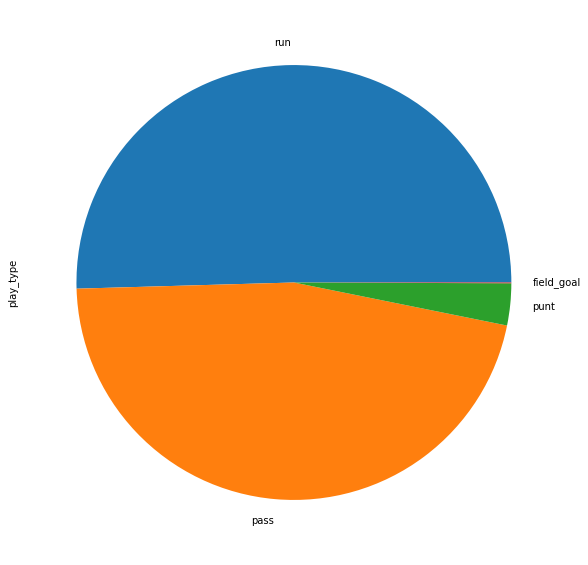

In [28]:
sample_df[sample_df['1 Play Calls Back'] == 'punt']['play_type'].value_counts().plot.pie(figsize=(16, 10))

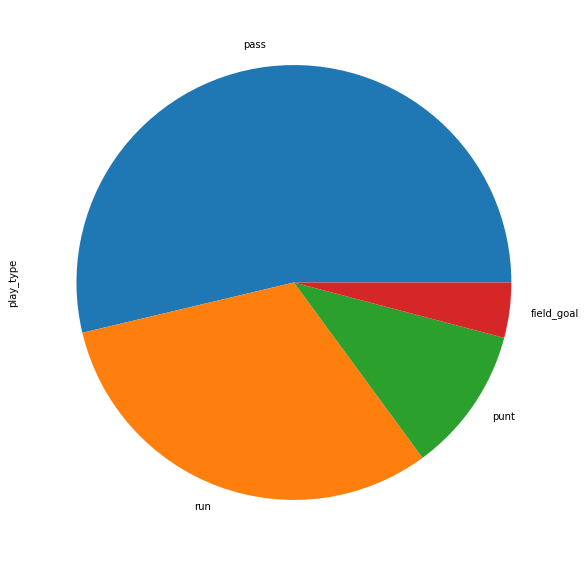

In [29]:
sample_df[sample_df['1 Play Calls Back'] == 'pass']['play_type'].value_counts().plot.pie(figsize=(16, 10))

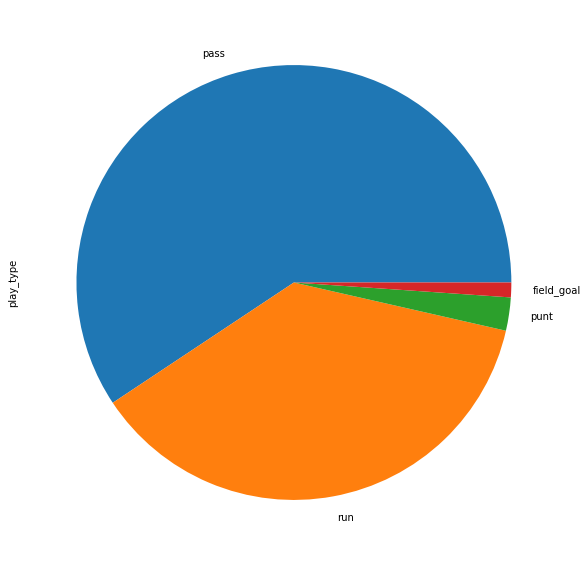

In [30]:
sample_df[sample_df['1 Play Calls Back'] == 'run']['play_type'].value_counts().plot.pie(figsize=(16, 10))

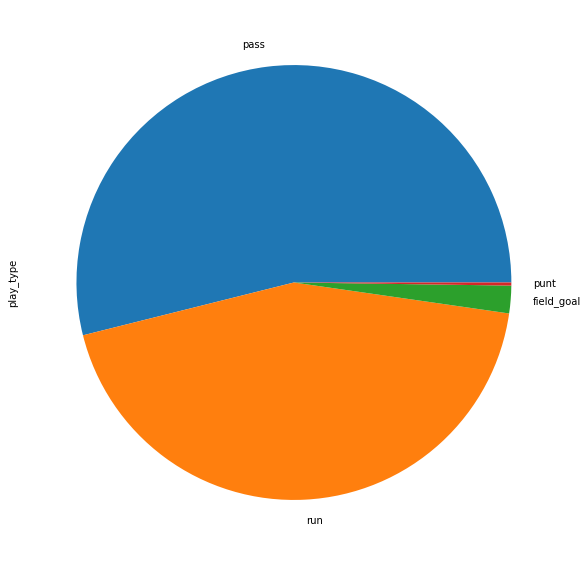

In [31]:
sample_df[sample_df['1 Play Calls Back'] == 'field_goal']['play_type'].value_counts().plot.pie(figsize=(16, 10))

In [37]:
dictionary_key['Play Types'] = {
    'N/A' : 0,
    'pass' : 1,
    'run' : 2,
    'punt': 3,
    'field_goal': 4
}

In [38]:
def get_play_type(play):
    return dictionary_key['Play Types'][play]

In [41]:
sample_df['home_team'] = sample_df['home_team'].apply(lambda x: get_team(x))
sample_df['away_team'] = sample_df['away_team'].apply(lambda x: get_team(x))
sample_df['posteam'] = sample_df['posteam'].apply(lambda x: get_team(x))
sample_df['defteam'] = sample_df['defteam'].apply(lambda x: get_team(x))
sample_df['posteam_type'] = sample_df['posteam_type'].apply(lambda x: get_team_type(x))
sample_df['side_of_field'] = sample_df['side_of_field'].apply(lambda x: get_side_field(x))
sample_df['season_type'] = sample_df['season_type'].apply(lambda x: get_season_type(x))
sample_df['game_half'] = sample_df['game_half'].apply(lambda x: get_game_half(x))
sample_df['1 Play Calls Back'] = sample_df['1 Play Calls Back'].apply(lambda x: get_play_type(x))
sample_df['2 Play Calls Back'] = sample_df['2 Play Calls Back'].apply(lambda x: get_play_type(x))
sample_df['3 Play Calls Back'] = sample_df['3 Play Calls Back'].apply(lambda x: get_play_type(x))
sample_df['4 Play Calls Back'] = sample_df['4 Play Calls Back'].apply(lambda x: get_play_type(x))
sample_df['5 Play Calls Back'] = sample_df['5 Play Calls Back'].apply(lambda x: get_play_type(x))

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [42]:
sample_df['home_team'] = sample_df['home_team'].astype('category')
sample_df['away_team'] = sample_df['away_team'].astype('category')
sample_df['posteam'] = sample_df['posteam'].astype('category')
sample_df['defteam'] = sample_df['defteam'].astype('category')
sample_df['posteam_type'] = sample_df['posteam_type'].astype('category')
sample_df['side_of_field'] = sample_df['side_of_field'].astype('category')
sample_df['game_half'] = sample_df['game_half'].astype('category')
sample_df['qtr'] = sample_df['qtr'].astype('category')
sample_df['down'] = sample_df['down'].astype('category')
sample_df['home_timeouts_remaining'] = sample_df['home_timeouts_remaining'].astype('category')
sample_df['away_timeouts_remaining'] = sample_df['away_timeouts_remaining'].astype('category')
sample_df['posteam_timeouts_remaining'] = sample_df['posteam_timeouts_remaining'].astype('category')
sample_df['defteam_timeouts_remaining'] = sample_df['defteam_timeouts_remaining'].astype('category')
sample_df['season_type'] = sample_df['season_type'].astype('category')
sample_df['1 Play Calls Back'] = sample_df['1 Play Calls Back'].astype('category')
sample_df['2 Play Calls Back'] = sample_df['2 Play Calls Back'].astype('category')
sample_df['3 Play Calls Back'] = sample_df['3 Play Calls Back'].astype('category')
sample_df['4 Play Calls Back'] = sample_df['4 Play Calls Back'].astype('category')
sample_df['5 Play Calls Back'] = sample_df['5 Play Calls Back'].astype('category')

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [43]:
X = sample_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = sample_df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
lgbm_params = {
    'clf__learning_rate': [0.1],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [50],
    'clf__max_depth': [20],
    'clf__num_leaves': [50],
    'clf__boosting_type': ['gbdt']
}
lgbm = LGBMClassifier()

In [1]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train, y_train)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))

NameError: name 'Pipeline' is not defined

### Total Yardage for Play Types

In [3]:
fixed_df = feather.read_dataframe('data/fixed_data_v1.feather')
fixed_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,season_type
0,59,2009080950,TEN,BUF,TEN,home,BUF,TEN,74.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
1,83,2009080950,TEN,BUF,TEN,home,BUF,TEN,64.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
2,104,2009080950,TEN,BUF,TEN,home,BUF,TEN,67.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
3,128,2009080950,TEN,BUF,TEN,home,BUF,TEN,55.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre
4,152,2009080950,TEN,BUF,TEN,home,BUF,BUF,40.0,8/9/09,...,3,3,3.0,3.0,0,0,0.0,0.0,0.0,pre


In [6]:
sample_df = fixed_df.loc[fixed_df['game_id'].isin(rand_games)]

In [14]:
sample_df['home_team_yards'] = 0
sample_df['away_team_yards'] = 0
sample_df['posteam_yards'] = 0
sample_df['defteam_yards'] = 0
sample_df['home_team_pass_yards'] = 0
sample_df['away_team_pass_yards'] = 0
sample_df['posteam_pass_yards'] = 0
sample_df['defteam_pass_yards'] = 0
sample_df['home_team_rush_yards'] = 0
sample_df['away_team_rush_yards'] = 0
sample_df['posteam_rush_yards'] = 0
sample_df['defteam_rush_yards'] = 0
def add_total_yardage(game_id):
    game_df = sample_df[sample_df['game_id'] == game_id]
    pass_rush_game_df = game_df.loc[game_df['play_type'].isin(['pass', 'run'])]
    home_team_df = pass_rush_game_df.loc[pass_rush_game_df['posteam'] == pass_rush_game_df['home_team']]
    away_team_df = pass_rush_game_df.loc[pass_rush_game_df['posteam'] == pass_rush_game_df['away_team']]
    yards = 0
    pass_yards = 0
    rush_yards = 0
    for play in home_team_df.itertuples():
        sample_df['home_team_yards'][play.Index] = yards
        sample_df['posteam_yards'][play.Index] = yards
        sample_df['home_team_pass_yards'][play.Index] = pass_yards
        sample_df['posteam_pass_yards'][play.Index] = pass_yards
        sample_df['home_team_rush_yards'][play.Index] = rush_yards
        sample_df['posteam_rush_yards'][play.Index] = rush_yards
        if play.play_type == 'pass':
            pass_yards += play.yards_gained
            yards += play.yards_gained
        else:
            rush_yards += play.yards_gained
            yards += play.yards_gained
    yards = 0
    pass_yards = 0
    rush_yards = 0
    for play in away_team_df.itertuples():
        sample_df['away_team_yards'][play.Index] = yards
        sample_df['posteam_yards'][play.Index] = yards
        sample_df['away_team_pass_yards'][play.Index] = pass_yards
        sample_df['posteam_pass_yards'][play.Index] = pass_yards
        sample_df['away_team_rush_yards'][play.Index] = rush_yards
        sample_df['posteam_rush_yards'][play.Index] = rush_yards
        if play.play_type == 'pass':
            pass_yards += play.yards_gained
            yards += play.yards_gained
        else:
            rush_yards += play.yards_gained
            yards += play.yards_gained

for game_id in rand_games:
    add_total_yardage(game_id)

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

KeyboardInterrupt: 

In [ ]:
def add_defteam_yardage(row):
    if row['defteam'] == row['home_team']:
        return row['home_team_yards']
    else:
        return row['away_team_yards']

def add_defteam_pass_yardage(row):
    if row['defteam'] == row['home_team']:
        return row['home_team_pass_yards']
    else:
        return row['away_team_pass_yards']

def add_defteam_rush_yardage(row):
    if row['defteam'] == row['home_team']:
        return row['home_team_rush_yards']
    else:
        return row['away_team_pass_yards']

In [ ]:
sample_df['defteam_yards'] = sample_df.apply(lambda x: add_defteam_yardage(x), axis=1)
sample_df['defteam_pass_yards'] = sample_df.apply(lambda x: add_defteam_pass_yardage(x), axis=1)
sample_df['defteam_rush_yards'] = sample_df.apply(lambda x: add_defteam_rush_yardage(x), axis=1)

In [ ]:
sample_df['home_team'] = sample_df['home_team'].apply(lambda x: get_team(x))
sample_df['away_team'] = sample_df['away_team'].apply(lambda x: get_team(x))
sample_df['posteam'] = sample_df['posteam'].apply(lambda x: get_team(x))
sample_df['defteam'] = sample_df['defteam'].apply(lambda x: get_team(x))
sample_df['posteam_type'] = sample_df['posteam_type'].apply(lambda x: get_team_type(x))
sample_df['side_of_field'] = sample_df['side_of_field'].apply(lambda x: get_side_field(x))
sample_df['season_type'] = sample_df['season_type'].apply(lambda x: get_season_type(x))
sample_df['game_half'] = sample_df['game_half'].apply(lambda x: get_game_half(x))

In [ ]:
sample_df['home_team'] = sample_df['home_team'].astype('category')
sample_df['away_team'] = sample_df['away_team'].astype('category')
sample_df['posteam'] = sample_df['posteam'].astype('category')
sample_df['defteam'] = sample_df['defteam'].astype('category')
sample_df['posteam_type'] = sample_df['posteam_type'].astype('category')
sample_df['side_of_field'] = sample_df['side_of_field'].astype('category')
sample_df['game_half'] = sample_df['game_half'].astype('category')
sample_df['qtr'] = sample_df['qtr'].astype('category')
sample_df['down'] = sample_df['down'].astype('category')
sample_df['home_timeouts_remaining'] = sample_df['home_timeouts_remaining'].astype('category')
sample_df['away_timeouts_remaining'] = sample_df['away_timeouts_remaining'].astype('category')
sample_df['posteam_timeouts_remaining'] = sample_df['posteam_timeouts_remaining'].astype('category')
sample_df['defteam_timeouts_remaining'] = sample_df['defteam_timeouts_remaining'].astype('category')
sample_df['season_type'] = sample_df['season_type'].astype('category')

In [ ]:
X = sample_df.drop(['play_type', 'play_id', 'game_id', 'game_date', 'time'], axis=1)
y = sample_df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lgbm_params = {
    'clf__learning_rate': [0.1],
    'clf__class_weight': ['balanced'],
    'clf__metric': ['multi_logloss'],
    'clf__max_bins': [50],
    'clf__max_depth': [20],
    'clf__num_leaves': [50],
    'clf__boosting_type': ['gbdt']
}
lgbm = LGBMClassifier()

In [ ]:
pipe = Pipeline([('clf', lgbm)])
gs = GridSearchCV(estimator=pipe,
                  param_grid=lgbm_params,
                  scoring='f1_weighted',
                  cv=3)
gs.fit(X_train, y_train)
best_svm = (gs.best_estimator_) 
print('LightGBM:')
print('Train Accuracy:',gs.best_estimator_.score(X_train, y_train))
print('Test Accuracy:',gs.best_estimator_.score(X_test, y_test))

In [ ]:
sample_df.to_csv('data/sample_data_yards.csv')